In [1]:
import json
from nltk.corpus import stopwords, words
import string 
import re
import spacy
from tqdm import tqdm 
from collections import defaultdict, Counter
import matplotlib.pyplot as plt 

In [2]:
with open('data/chunked_data/gdpr_chunk.json') as f: 
    gdpr_chunked = json.load(f)

In [3]:
nlp = spacy.load("en_core_web_sm", disable=['ner', 'textcat'])
clean_stopwords = set(stopwords.words('english')).difference(set('not'))
clean_punctuation = ''.join(set(string.punctuation).difference(set(['()', '(', ')'])))

In [4]:
def lemmatize(text):
    return ' '.join(token.lemma_ for token in nlp(text))

In [6]:
gdpr_clean = defaultdict(dict)
for k in tqdm(gdpr_chunked.keys()):
    for sub_k in gdpr_chunked[k].keys():
        text = gdpr_chunked[k][sub_k]
        #Remove punctuation
        text = text.translate(str.maketrans('', '', '.,;:[]()\'')) 
        #Remove extra whitespaces, stopwords and lemmatize
        text = ' '.join(i.lower().strip() for i in lemmatize(text).split() if i not in clean_stopwords and len(i)>=2)
        gdpr_clean[k][sub_k] = text

100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


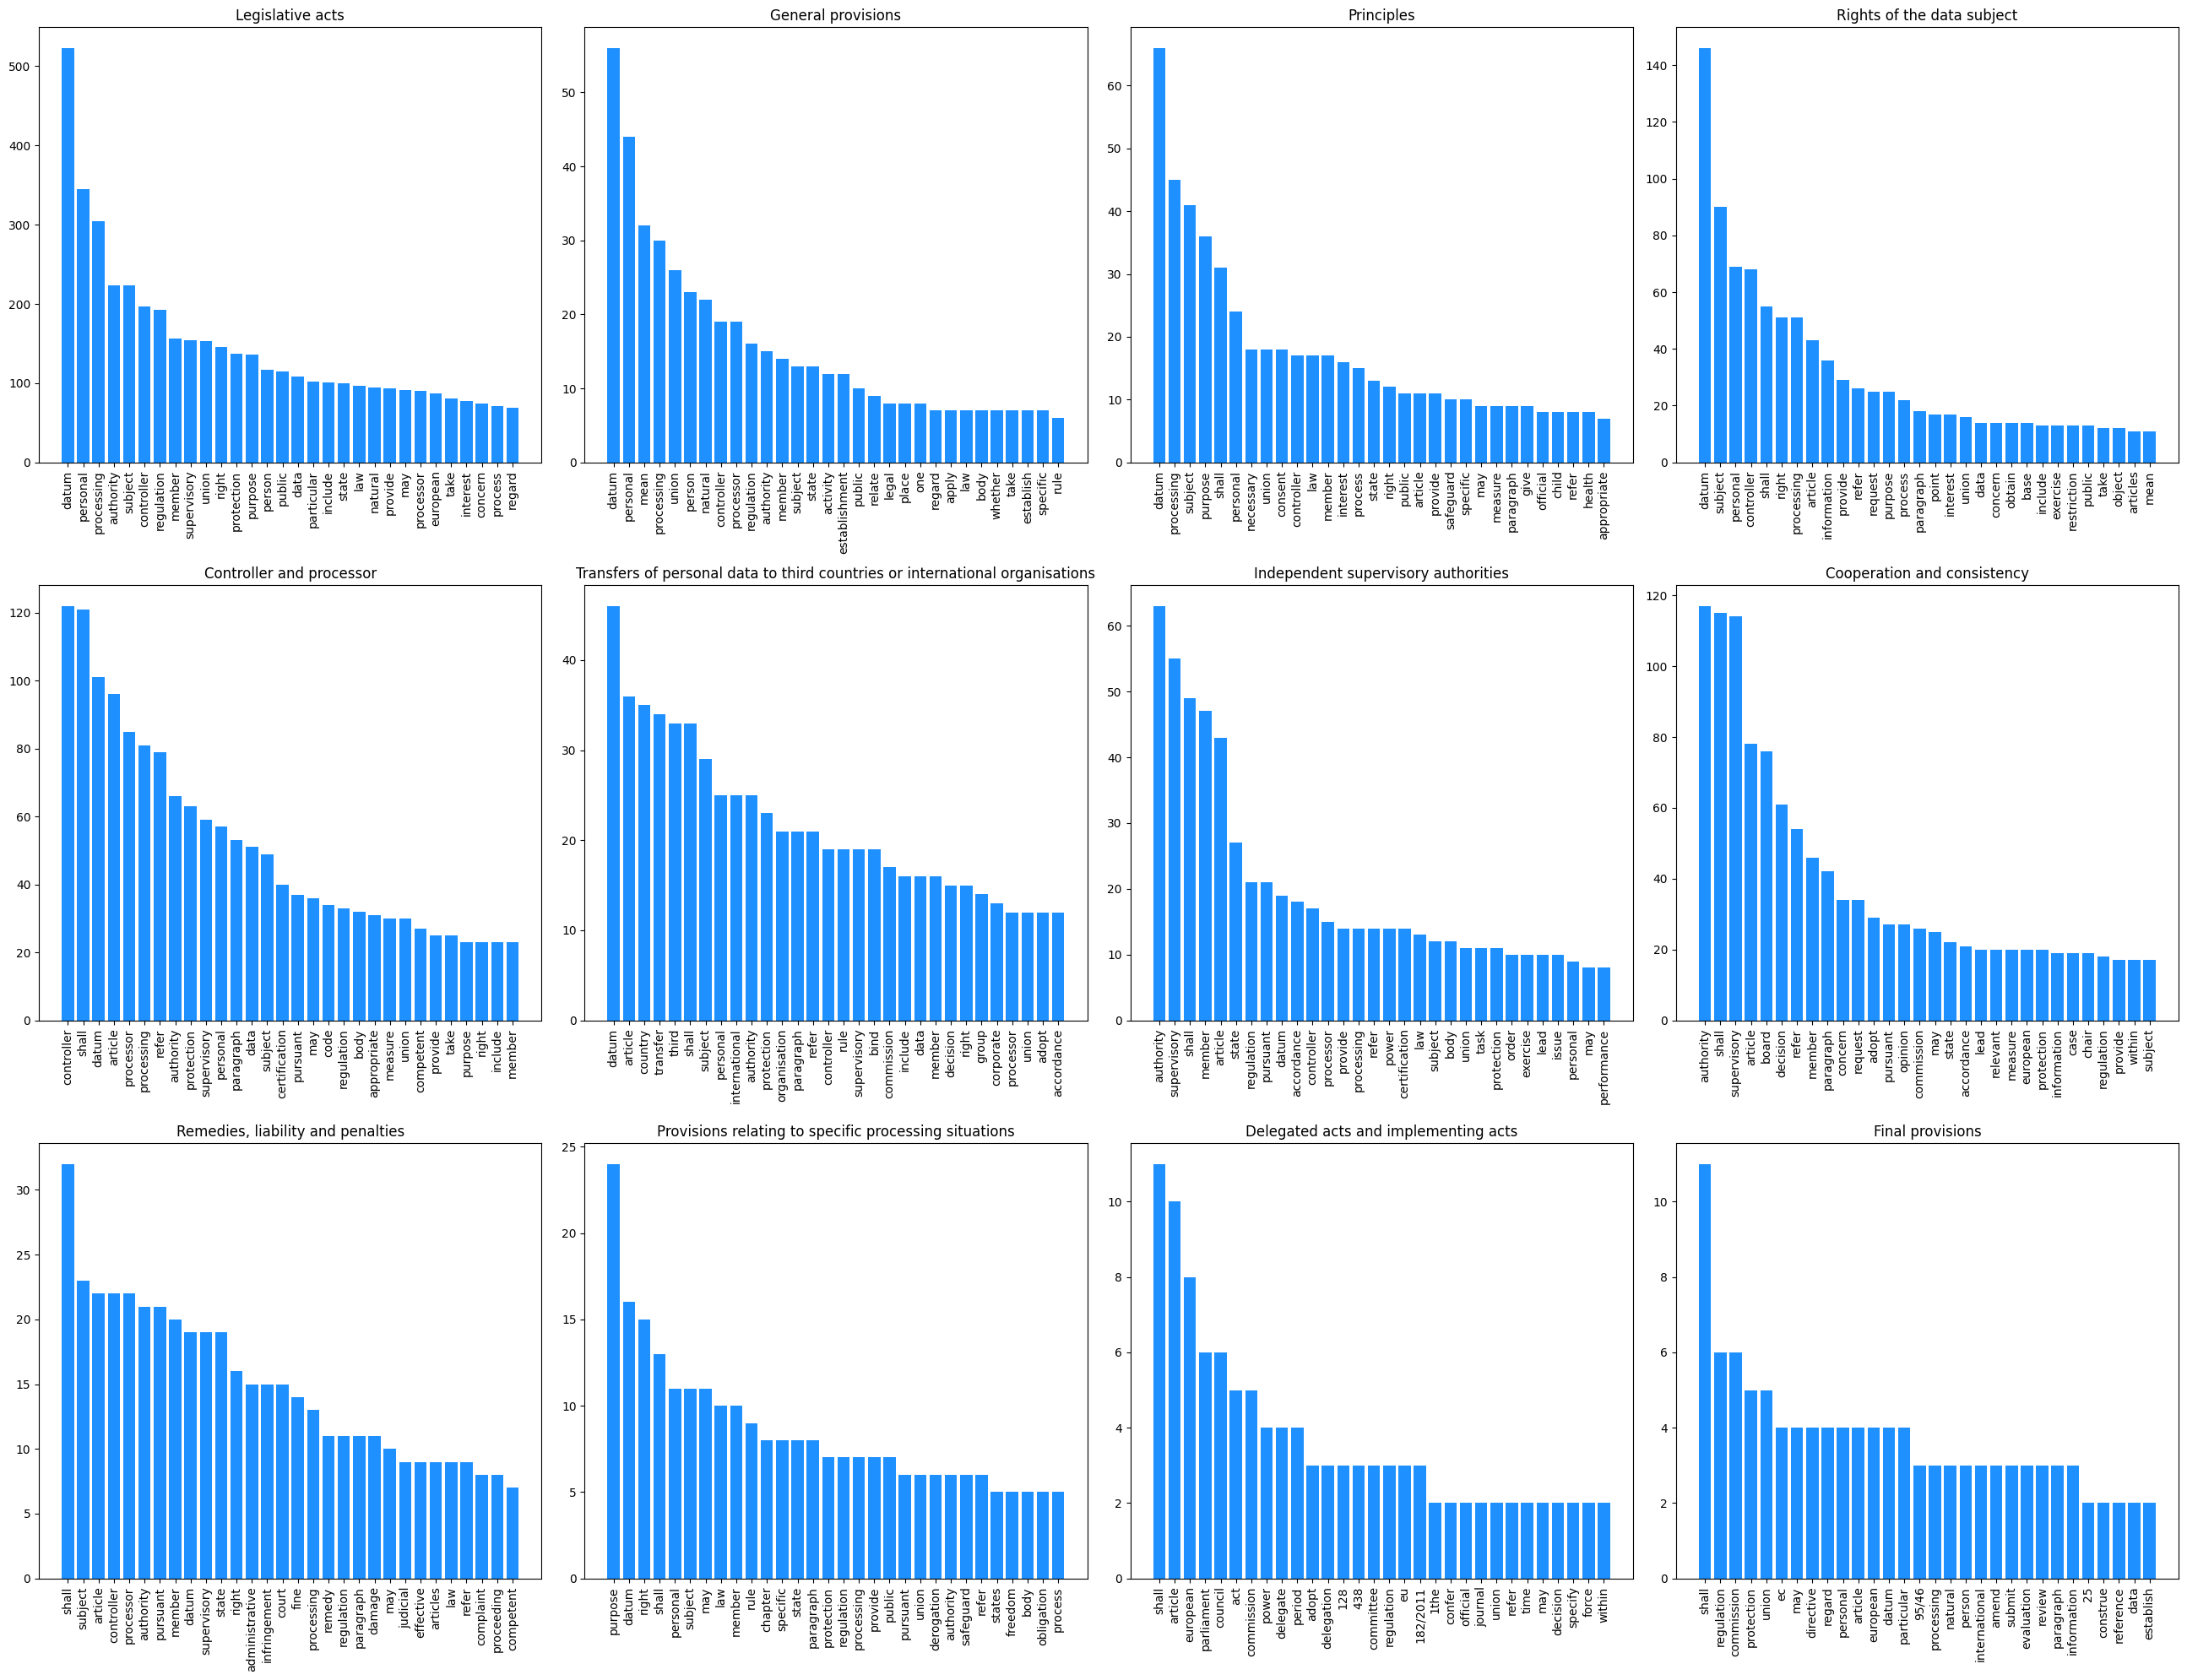

In [8]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(26,20))
axs=axs.ravel()
chapters = list(gdpr_clean.keys())
for i in range(len(axs)):
    ax = axs[i]
    chapter = chapters[i]
    top_20_words = Counter(' '.join(gdpr_clean[chapter].values()).split()).most_common(30)
    x_labs = [x for x,y in top_20_words]
    y_vals = [y for x,y in top_20_words]
    ax.bar(x=x_labs, height=y_vals, color='dodgerblue')
    ax.set_title(f'{chapter}')
    ax.tick_params(axis='x', labelrotation=90)

plt.tight_layout()    
plt.show()

In [9]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('Alibaba-NLP/gte-base-en-v1.5', trust_remote_code=True)

embeddings = []
chapter = []
article = []
for k in tqdm(gdpr_clean.keys()):
    for sub_k in gdpr_clean[k].keys():
        embeddings.append(model.encode(gdpr_clean[k][sub_k]))
        chapter.append(k)
        article.append(sub_k)

c:\Users\faceru\AppData\Local\Programs\Python\Python312\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
100%|██████████| 12/12 [00:57<00:00,  4.75s/it]


In [10]:
from sklearn.manifold import TSNE
import plotly.express as px
import numpy as np
import pandas as pd

In [11]:
embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42).fit_transform(np.array(embeddings))
embedded_df = pd.DataFrame({'x': embedded[:,0], 'y':embedded[:,1], 'chapter':chapter, 'article':article})
px.scatter(embedded_df, 'x', 'y', color='chapter')